# Questions

 1) Does the connectivity in a QC matter? Meaning that can we really only perform two qubit operations on qubits that are connected? For example in Starmon5

 2) How do we search for the values of \Gamma, \Beta? Here it is done classically by sutdying the mean value of the cost function which was computed classically (by hand)
 
 3) How do we compute the mean value of the cost function (the hamilonian H) for a general graph? In this article it is computed by hand. In general, this is only possible for graphs with bounded degree (degree of a vertice == number of edges in the vertice) and low depth. So the  
  

In [2]:
%matplotlib inline

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

#import pennylane
import pennylane as qml
from pennylane import numpy as np

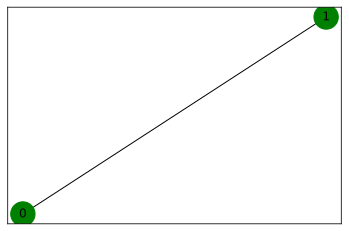

In [52]:
# Generating the butterfly graph with 5 nodes 
n     = 2
V     = np.arange(0,n,1)
E     =[(0,1,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['g' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)


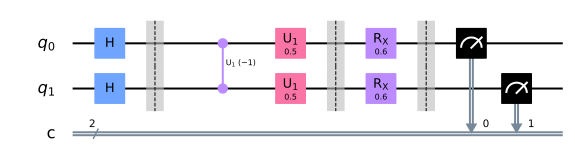

In [83]:

gamma = 0.5
beta = 0.3
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cu1(-2*gamma, k, l)
    QAOA.u1(gamma, k)
    QAOA.u1(gamma, l)
    
# then apply the single qubit X - rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the all qubits in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw(output='mpl')

# Local simulator

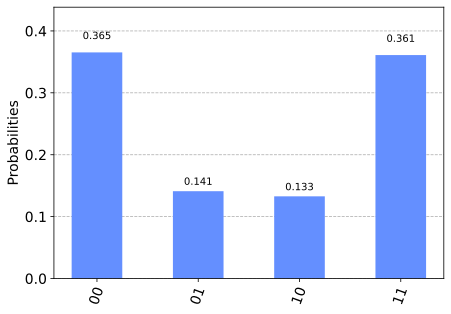

In [84]:
# run on local simulator

backend = Aer.get_backend("qasm_simulator")
shots = 10000

simulate = execute(QAOA, backend=backend, shots=shots)
results = simulate.result()

plot_histogram(results.get_counts())

# Quantum inspire backend

Job Status: job has successfully run


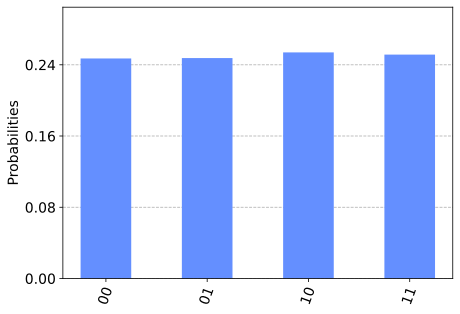

In [78]:
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

save_account('baeb3be4d807b3b6d170dc2d6de5c1b02b1606d1') #saves account with my API token
QI.set_authentication()

qi_backend = QI.get_backend('QX single-node simulator') #quantum inspire simulator
shots = 2048

job = execute(QAOA, backend=qi_backend, shots=shots) #execute the quantum circuit
job_monitor(job) #to monitor the job queu

results = job.result() 
counts = results.get_counts() #the method .get_counts of the class result returns a dictionary holding the counts of the measurements
plot_histogram(counts, bar_labels = False)



In [79]:
# Evaluate the data from the experiment

# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

counts = exp_results.get_counts()

avr_cost  = 0
max_cost = 0
hist        = {} 

for state in list(counts.keys()): #iterating over all measured states

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(state)] #the bit string is saved as a list
    cost_x   = cost_function_C(x,G)

    # compute the expectation value
    avr_cost += counts[state]*cost_x

    # save best bit string
    if max_cost < cost_x:
        max_cost = cost_x

avr_cost = avr_cost/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The expectation value of the cost function is = {avr_cost}')
#print('The approximate solution is x* = {ma} with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
#plot_histogram(hist,bar_labels = False)



 --- EXPERIMENTAL RESULTS ---

The expectation value of the cost function is = {avr_cost}
The cost function is distributed as: 



In [89]:
import grid